In [1]:
import lettuce as lt
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

import warnings
import numpy as np
from lettuce.unit import UnitConversion
from lettuce.util import append_axes
from lettuce.boundary import EquilibriumBoundaryPU, BounceBackBoundary, HalfwayBounceBackBoundary, FullwayBounceBackBoundary, EquilibriumOutletP, AntiBounceBackOutlet
from lettuce.flows.obstaclemax import ObstacleMax

import torch
import time
import datetime
import os
import shutil

In [2]:
### Simulationsparameter - Steuerung 
re = 200    # Reynoldszahl
Ma=0.05     # Machzahl
n_steps = 150000    # Schrittzahl
setup_diameter = 1  # D_PU = char_length_pu -> this defines the PU-Reference
flow_velocity = 1  # U_PU = char_velocity_pu -> this defines the PU-Reference velocity (u_max of inflow)

gridpoints_per_diameter = 40  # gp_per_D -> this defines the resolution
domain_width_in_D = 20  # D/Y  -> this defines the domain-size and total number of Lattice-Nodes
domain_length_in_D = 2*domain_width_in_D  # D/X

T_target=140
print("shape_LU:", gridpoints_per_diameter*domain_length_in_D, "x", gridpoints_per_diameter*domain_width_in_D)
print("T with", n_steps, "steps:", round(n_steps * (setup_diameter/gridpoints_per_diameter)*(Ma*1/np.sqrt(3)/flow_velocity),2), "seconds")
print("n_steps to simulate 1 second:", round((gridpoints_per_diameter/setup_diameter)*(flow_velocity/(Ma*1/np.sqrt(3))),2), "steps")
print("n_steps to simulate",T_target,"seconds:",T_target*round((gridpoints_per_diameter/setup_diameter)*(flow_velocity/(Ma*1/np.sqrt(3))),2), "steps")

u_init = 0    # initiales Geschwindigkeitsfeld: # 0: uniform u=0, # 1: uniform u=1, # 2: parabolic, amplitude u_char_lu (similar to poiseuille-flow)
perturb_init = True   # leichte Asymmetrie in Anfangs-Geschwindigkeitsverteilung -> triggert Karman'sche Wirbelstraße für Re>47
bb_wall = False    # Randbedingungen der lateralen Kanalwände: True= bounce-back-walls und parabelförmiges Geschwindigkeisprodil am Einlass, False= periodic BC und uniforme Geschwindigkeit am Einlass
cylinder = True    # Objekt: True = cylinder, False = no obstascle
halfway = True    # BounceBackBoundary-Algorithmus: True=Halfway, False=Fullway
drag_out = True    # drag_coefficient als observable-reporter
lift_out = True    # lift_coefficient als observable-reporter
vtk_fps=10    # FramesPerSecond (/PU) für vtk-output

#exmpl: Re1000,steps25000,ny1000 braucht 43min
#Bonn: Re200, steps200000,gpd20?, 400x200 braucht 10min
#HBRS: Re200, steps100000, gpd20, 800x400 braucht 25min

mlups_2060super = 20
mlups_2080ti = 30

print("generates approx.", int(vtk_fps*(n_steps * (setup_diameter/gridpoints_per_diameter)*(Ma*1/np.sqrt(3)/flow_velocity)))+1, ".vti/.vtk-frames")

gridpoints = gridpoints_per_diameter**2*domain_length_in_D*domain_width_in_D
print("No. of gridpoints:", gridpoints)
print("estimated min. runtime on 2060super:", round(n_steps*gridpoints/(1e6*mlups_2060super),2), "seconds (", round(n_steps*gridpoints/(1e6*mlups_2060super)/60,2),"minutes )")
print("estimated min. runtime on 2080ti:   ", round(n_steps*gridpoints/(1e6*mlups_2080ti),2), "seconds (", round(n_steps*gridpoints/(1e6*mlups_2080ti)/60,2),"minutes )")

shape_LU: 1600 x 800
T with 150000 steps: 108.25 seconds
n_steps to simulate 1 second: 1385.64 steps
n_steps to simulate 140 seconds: 193989.6 steps
generates approx. 1083 .vti/.vtk-frames
No. of gridpoints: 1280000
estimated min. runtime on 2060super: 9600.0 seconds ( 160.0 minutes )
estimated min. runtime on 2080ti:    6400.0 seconds ( 106.67 minutes )


In [3]:
### Data_Output (vtk)
output_save = True
if output_save:  # toggle output
    vtk_out = True    # vtk-Repoter für Animation des Flusses in ParaView: True = vtk-output, False = no vtk-output

    timestamp = datetime.datetime.now()
    timestamp = timestamp.strftime("%y%m%d")+"_"+timestamp.strftime("%H%M%S")

    #output_path = "/mnt/ScratchHDD1/Max_Scratch/lbm_simulations"  # lokal HBRS
    output_path = "/home/max/Documents/lbm_simulations"  # lokal Bonn
    dir_name = "/data_" + str(timestamp) + ""
    os.makedirs(output_path+dir_name)
    
    vtk_path = output_path+dir_name+"/vtk/out"    # lokal HBRS UND Bonn # Pfad und Name der vtk-output-Dateien
    print("dir_name: "+dir_name)
    print("output_path: " + vtk_path)
else:
    vtk_out = False

dir_name: /data_230329_193646
output_path: /home/max/Documents/lbm_simulations/data_230329_193646/vtk/out


In [4]:
### Simulationssetup

# lattice
lattice = lt.Lattice(lt.D2Q9, "cuda:0", dtype=torch.float64)
    # stencil, device, dtype

flow = ObstacleMax(reynolds_number=re, mach_number=Ma, 
                   lattice=lattice, 
                   char_length_pu=setup_diameter, 
                   char_length_lu=gridpoints_per_diameter, 
                   char_velocity_pu=flow_velocity, 
                   y_cl=domain_width_in_D, 
                   x_cl=domain_length_in_D, 
                   lateral_walls=bb_wall, 
                   hwbb=halfway, 
                   perturb_init=perturb_init, 
                   u_init=u_init
                  )

# define a Cylinder-Obstacle
radius = 0.5 * flow.char_length_pu
x_pos = 0.25 * flow.domain_length_cl
y_pos = 0.5 * flow.domain_width_cl
x, y = flow.grid
condition = np.sqrt((x - x_pos) ** 2 + (y - y_pos) ** 2) < radius  # (x-x0)²+(y-y0)²<r² in PU
flow.obstacle_mask[np.where(condition)] = 1
    
    
### Simulations-Objekt (Simulator)
tau = flow.units.relaxation_parameter_lu
sim = lt.Simulation(flow, lattice, 
                     lt.BGKCollision(lattice, tau),
                    # lt.RegularizedCollision(lattice, tau), 
                    # lt.KBCCollision2D(lattice,tau),
                    lt.StandardStreaming(lattice)
                   )
    # Flow, Lattice-Parameter, KollisionsOperator-Objekt(Parameter), Streaming-Objekt

### Reporter

# VTK Reporter -> Visualisierung
if vtk_out == True:
    VTKreport = lt.VTKReporter(lattice, flow, interval=int(flow.units.convert_time_to_lu(1/vtk_fps)), filename_base=vtk_path)
    sim.reporters.append(VTKreport)

# Observable reporter: drag coefficient
if drag_out == True:
    DragObservable = lt.DragCoefficient(lattice,flow,sim,area=setup_diameter)  # erstelle Observable // ! area A=2*r is in PU
    Dragreport = lt.ObservableReporter(DragObservable, out=None)  # erstelle Reporter für Observable
    sim.reporters.append(Dragreport)  # hänge Reporter in Simulator ein
    
# Observable reporter: lift coefficient
if lift_out == True:
    LiftObservable = lt.LiftCoefficient(lattice,flow,sim,area=setup_diameter)
    Liftreport = lt.ObservableReporter(LiftObservable, out=None)
    sim.reporters.append(Liftreport)
    
# MassObservable = lt.Mass(lattice,flow)
# MassReporter = lt.ObservableReporter(MassObservable, out=None)
# sim.reporters.append(MassReporter)

In [5]:
### calculate necessary No. of steps to simulate T seconds
T=150
l_char_lu=flow.units.characteristic_length_lu
l_char_pu=flow.units.characteristic_length_pu
u_char_lu=flow.units.characteristic_velocity_lu
u_char_pu=flow.units.characteristic_velocity_pu
n_steps_prediction = T*l_char_lu/l_char_pu*u_char_pu/u_char_lu

print("Domain size:", flow.shape[0], "x", flow.shape[1])

print("steps for", T, "seconds:", n_steps_prediction)

print("time simulated with set", n_steps, "steps:", flow.units.convert_time_to_pu(n_steps), "seconds")

if output_save:
    print("generates approx.", int(vtk_fps*flow.units.convert_time_to_pu(n_steps))+1, ".vti/.vtk-frames")

Domain size: 1600 x 800
steps for 150 seconds: 207846.09690826523
time simulated with set 150000 steps: 108.25317547305485 seconds
generates approx. 1083 .vti/.vtk-frames


In [6]:
### Einfache Simulation

t_start=time.time()

mlups = sim.step(n_steps) #Simulation mit Schrittzahl n_steps

t_end=time.time()
runtime=t_end-t_start
print("MLUPS:", mlups)
print("PU-Time: ",flow.units.convert_time_to_pu(n_steps)," seconds")
print("Re:",re)
print("char_velocity_LU", flow.units.characteristic_velocity_lu)
print("number of steps:",n_steps)
print("runtime: ",runtime, "seconds")

MLUPS: 39.33078689920543
PU-Time:  108.25317547305485  seconds
Re: 200
char_velocity_LU 0.028867513459481294
number of steps: 150000
runtime:  4881.672079563141 seconds


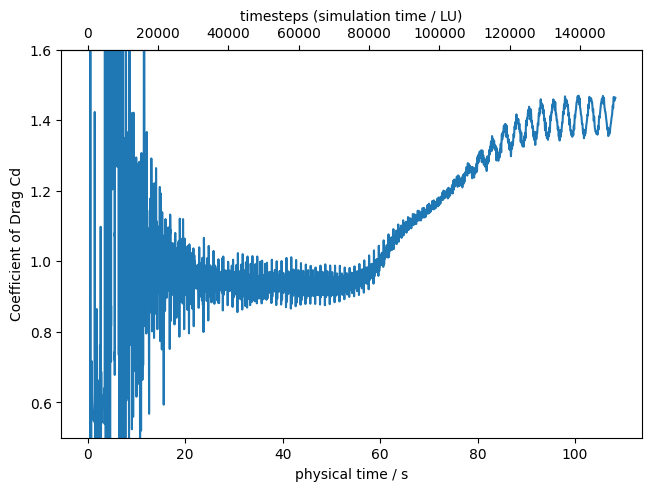

In [7]:
### plot Drag coefficient

drag_coefficient = np.array(Dragreport.out)
#print('  stepLU        ', 'timePU        ', 'Cd')
#print(drag_coefficient) # prints: stepLU, timePU, value

fig, ax = plt.subplots(constrained_layout=True)
ax.plot(drag_coefficient[:,1],drag_coefficient[:,2])
ax.set_xlabel("physical time / s")
ax.set_ylabel("Coefficient of Drag Cd")
ax.set_ylim([0.5,1.6])

secax = ax.secondary_xaxis('top', functions=(flow.units.convert_time_to_lu, flow.units.convert_time_to_pu))
secax.set_xlabel("timesteps (simulation time / LU)")
if output_save:
    plt.savefig(output_path+dir_name+"/drag_coefficient.png")
    np.savetxt(output_path+dir_name+"/drag_coefficient.txt", drag_coefficient, header="stepLU  |  timePU  |  Cd  FROM str(timestamp)")
plt.show()

# plt.figure
# plt.plot(drag_coefficient[:,1],drag_coefficient[:,2])
# plt.xlabel("time/s")
# plt.
# plt.ylim([1,1.5])

In [16]:
### calculate mean drag_coefficient in periodic reagion:
values = drag_coefficient[int(drag_coefficient.shape[0]*0.85-1):,2]

peaks_max = find_peaks(values, prominence=((values.max()-values.min())/2))
peaks_min = find_peaks(-values, prominence=((values.max()-values.min())/2))

if peaks_min[0].shape[0] - peaks_max[0].shape[0] > 0:
    peak_number = peaks_max[0].shape[0]
else:
    peak_number = peaks_min[0].shape[0]

if peaks_min[0][0] < peaks_max[0][0]:
    first_peak = peaks_min[0][0]
    last_peak = peaks_max[0][peak_number-1]
else:
    first_peak = peaks_max[0][0]
    last_peak = peaks_min[0][peak_number-1]

drag_mean = values[first_peak:last_peak].mean()
drag_mean_simple = values.mean()

print("simple mean:     ",drag_mean_simple)
print("peak_finder mean:",drag_mean)

drag_mean_simple_GPDcorrected = drag_mean_simple/(1+1/gridpoints_per_diameter)
drag_mean_GPDcorrected = drag_mean/(1+1/gridpoints_per_diameter)
print("simple mean GPD-corrected:     ", drag_mean_simple_GPDcorrected)
print("peak-finder mean GPD-corrected:", drag_mean_GPDcorrected)

simple mean:      1.4133463525727796
peak_finder mean: 1.41261196840785
simple mean GPD-corrected:      1.378874490314907
peak-finder mean GPD-corrected: 1.3781580179588782


In [17]:
print("start time of 'mean'-ing:",drag_coefficient[int(drag_coefficient.shape[0]*0.90-1),1])

start time of 'mean'-ing: 97.42713623791288


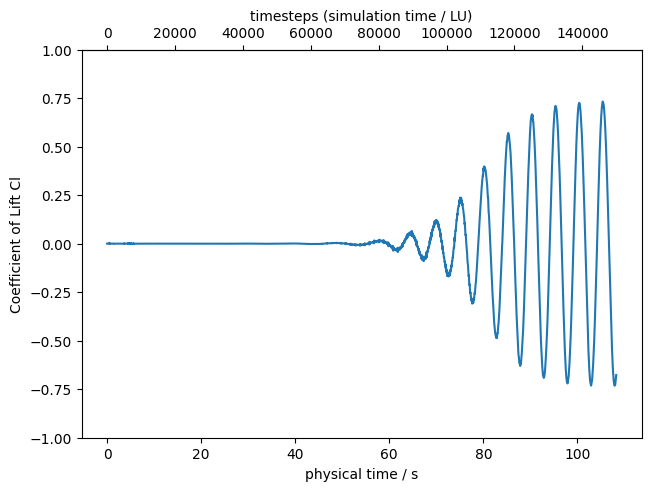

Cl_peaks: 
min -0.7317188511052507 
max 0.7326448503833694
Cl_peaks (gpd-corrected): 
min -0.7138720498587813 
max 0.7147754637886531


In [10]:
### plot Lift coefficient

lift_coefficient = np.array(Liftreport.out)
# print('  stepLU        ', 'timePU        ', 'Cl')
# print(lift_coefficient) # prints: stepLU, timePU, value
# plt.figure
# plt.plot(lift_coefficient[:,0],lift_coefficient[:,2])
# plt.ylim([-1,1])

fig, ax = plt.subplots(constrained_layout=True)
ax.plot(lift_coefficient[:,1],lift_coefficient[:,2])
ax.set_xlabel("physical time / s")
ax.set_ylabel("Coefficient of Lift Cl")
ax.set_ylim([-1,1])

secax = ax.secondary_xaxis('top', functions=(flow.units.convert_time_to_lu, flow.units.convert_time_to_pu))
secax.set_xlabel("timesteps (simulation time / LU)")
if output_save:
    plt.savefig(output_path+dir_name+"/lift_coefficient.png")
    np.savetxt(output_path+dir_name+"/lift_coefficient.txt", lift_coefficient, header="stepLU  |  timePU  |  Cl  FROM str(timestamp)")
plt.show()

print("Cl_peaks: \nmin", lift_coefficient[:,2].min(),"\nmax", lift_coefficient[:,2].max())
print("Cl_peaks (gpd-corrected): \nmin", lift_coefficient[:,2].min()/(1+1/gridpoints_per_diameter),"\nmax", lift_coefficient[:,2].max()/(1+1/gridpoints_per_diameter))

max. Amplitude np.abx(X).max(): 14450.100742507579
Frequency Peak: 0.19398839719173294 +- 0.009237542723415855 Hz


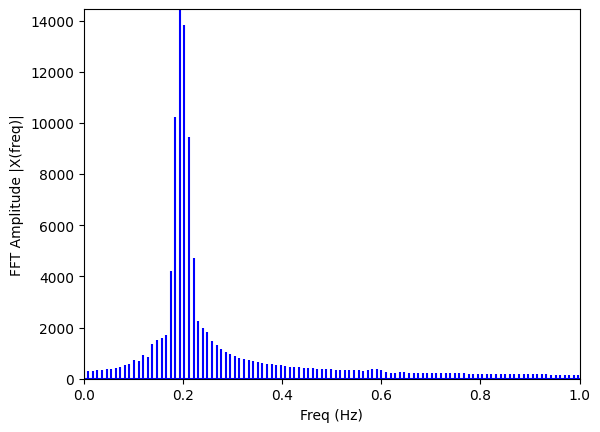

In [11]:
### prototyped fft for frequency detection and calculation of strouhal-number
# ! Drag_frequency is 2* Strouhal-Freq. Lift-freq. is Strouhal-Freq.

X = np.fft.fft(lift_coefficient[:,2])
N = len(X)
n = np.arange(N)
T = N*flow.units.convert_time_to_pu(1)
freq = n/T

plt.figure
plt.stem(freq, np.abs(X), 'b', markerfmt=" ", basefmt="-b")
plt.xlabel("Freq (Hz)")
plt.ylabel("FFT Amplitude |X(freq)|")
plt.xlim(0,1)
print("max. Amplitude np.abx(X).max():", np.abs(X).max())
plt.ylim(0,np.abs(X[:int(X.shape[0]*0.5)]).max())

freq_res = freq[1]-freq[0]
X_abs = np.abs(X[:int(X.shape[0]*0.5)])
freq_peak = freq[np.argmax(X_abs)]
print("Frequency Peak:", freq_peak, "+-", freq_res, "Hz")
# f = Strouhal for St=f*D/U and D=U=1 in PU

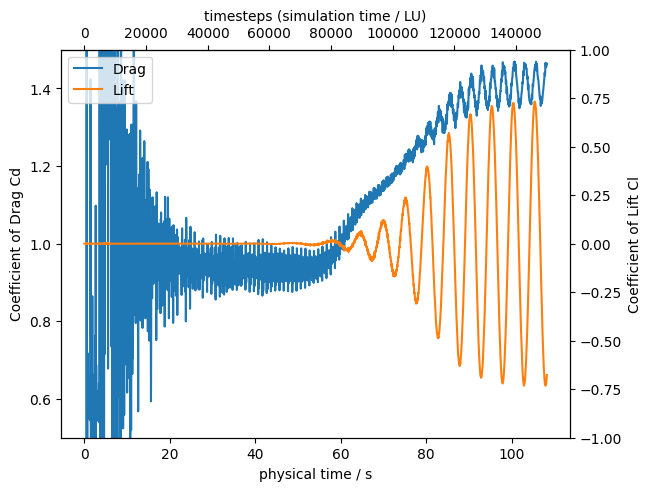

In [12]:
### plot Drag coefficient AND Lift Coefficient

drag_coefficient = np.array(Dragreport.out)
lift_coefficient = np.array(Liftreport.out)

fig, ax = plt.subplots(layout="constrained")
drag_ax = ax.plot(drag_coefficient[:,1],drag_coefficient[:,2], color="tab:blue", label="Drag")
ax.set_xlabel("physical time / s")
ax.set_ylabel("Coefficient of Drag Cd")
ax.set_ylim([0.5,1.5])

secax = ax.secondary_xaxis('top', functions=(flow.units.convert_time_to_lu, flow.units.convert_time_to_pu))
secax.set_xlabel("timesteps (simulation time / LU)")

ax2 = ax.twinx()
lift_ax = ax2.plot(lift_coefficient[:,1],lift_coefficient[:,2], color="tab:orange", label="Lift")
ax2.set_ylabel("Coefficient of Lift Cl")
ax2.set_ylim([-1,1])


fig.legend(loc="upper left", bbox_to_anchor=(0,1), bbox_transform=ax.transAxes)

if output_save:
    plt.savefig(output_path+dir_name+"/dragAndLift_coefficient.png")

plt.show()

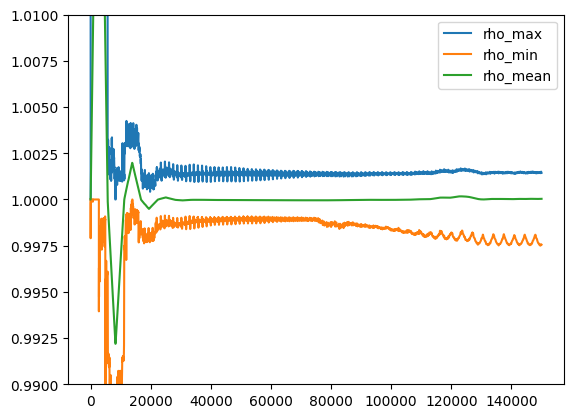

In [13]:
### plotte Dichte (mean, max, min) im Fluid-Bereich

plt.figure
plt.plot(np.arange(len(DragObservable.rho_max_list)),DragObservable.rho_max_list)
plt.plot(np.arange(len(DragObservable.rho_min_list)),DragObservable.rho_min_list)
plt.plot(np.arange(len(DragObservable.rho_mean_list)),DragObservable.rho_mean_list)
plt.legend(labels=["rho_max", "rho_min", "rho_mean"])
plt.ylim([0.99,1.01])
if output_save:
    plt.savefig(output_path+dir_name+"/density.png")

In [14]:
# save notebook to simulation_output
if output_save:
    shutil.copy(str(os.getcwd())+"/cylinder2D_development.ipynb",output_path+dir_name+"/script.ipynb")
else:
    print("output_save-toggle is FALSE")


In [19]:
# output data
if output_save:
    output_file = open(output_path+dir_name+"/"+timestamp + "_parameters_and_observables.txt", "a")
    output_file.write("DATA for "+timestamp)
    output_file.write("\n\n###################\n\nSIM-Parameters")
    output_file.write("\nRe = "+str(re))
    output_file.write("\nMa = "+str(Ma))
    output_file.write("\nn_steps = "+str(n_steps))
    output_file.write("\nsetup_diameter (D_PU) = "+str(setup_diameter))
    output_file.write("\nflow_velocity (U_PU) = "+str(flow_velocity))
    output_file.write("\ngridpoints_per_diameter (gpd) = "+str(gridpoints_per_diameter))
    output_file.write("\ndomain_width_in_D (D/Y) = "+str(domain_width_in_D))
    output_file.write("\ndomain_length_in_D (D/X) = "+str(domain_length_in_D))
    output_file.write("\n")
    output_file.write("\nu_init = "+str(u_init))
    output_file.write("\nperturb_init = "+str(perturb_init))
    output_file.write("\nbb_wall = "+str(bb_wall))
    output_file.write("\nhwbb BC = "+str(halfway))
    output_file.write("\nvtk_fps = "+str(vtk_fps))
    output_file.write("\n")
    output_file.write("\nshape_LU: "+ str(gridpoints_per_diameter*domain_length_in_D) + " x " + str(gridpoints_per_diameter*domain_width_in_D))
    output_file.write("\ntotal No. of gridpoints: "+ str(gridpoints))
    output_file.write("\n")
    output_file.write("output_dir: "+str(output_path+dir_name))
    output_file.write("\n")
    output_file.write("\n###################\n\ncylinder:")
    output_file.write("\nradius = "+str(radius))
    output_file.write("\nx_pos = "+str(x_pos))
    output_file.write("\ny_pos = "+str(y_pos))
    output_file.write("\ntau = "+str(tau))
    output_file.write("\n")
    output_file.write("\n###################\n\nSTATS:")
    output_file.write("\nT_PU = "+str(flow.units.convert_time_to_pu(n_steps))+" seconds")
    output_file.write("\nruntime = "+str(runtime)+ " seconds (="+str(runtime/60)+" minutes)")
    output_file.write("\nMLUPS = "+str(mlups))
    output_file.write("\n")
    output_file.write("\n###################\n\nOBSERVABLES:")
    output_file.write("\nCoefficient of drag between "+str(round(drag_coefficient[int(drag_coefficient.shape[0]*0.85-1),1],2))+" s and "+str(round(drag_coefficient[int(drag_coefficient.shape[0]-1),1],2))+" s:")
    output_file.write("\nCd_mean, simple      = "+str(drag_mean_simple))
    output_file.write("\nCd_mean, peak_finder = "+str(drag_mean))
    output_file.write("\nCd_min = "+str(drag_coefficient[int(drag_coefficient.shape[0]*0.85-1):,2].min()))
    output_file.write("\nCd_max = "+str(drag_coefficient[int(drag_coefficient.shape[0]*0.85-1):,2].max()))
    output_file.write("\n - GPD-corrected: - ")
    output_file.write("\n(gpd_corr.) Cd_mean, simple      = "+str(drag_mean_simple/(1+1/gridpoints_per_diameter)))
    output_file.write("\n(gpd_corr.) Cd_mean, peak_finder = "+str(drag_mean/(1+1/gridpoints_per_diameter)))
    output_file.write("\n(gpd_corr.) Cd_min = "+str(drag_coefficient[int(drag_coefficient.shape[0]*0.85-1):,2].min()/(1+1/gridpoints_per_diameter)))
    output_file.write("\n(gpd_corr.) Cd_max = "+str(drag_coefficient[int(drag_coefficient.shape[0]*0.85-1):,2].max()/(1+1/gridpoints_per_diameter)))
    output_file.write("\n")
    output_file.write("\nCoefficient of lift:")
    output_file.write("\nCl_min = "+str(lift_coefficient[:,2].min()))
    output_file.write("\nCl_max = "+str(lift_coefficient[:,2].max()))
    output_file.write("\n - GPD-corrected: - ")
    output_file.write("\nCl_min = "+str(lift_coefficient[:,2].min()/(1+1/gridpoints_per_diameter)))
    output_file.write("\nCl_max = "+str(lift_coefficient[:,2].max()/(1+1/gridpoints_per_diameter)))
    output_file.write("\n")
    output_file.write("\nStrouhal number:")
    output_file.write("\nf +- df = "+str(freq_peak)+" +- "+str(freq_res)+" Hz")
    output_file.close()
    